# Subdomain Flow Testing

Simulates what the LLM would do for real user questions: READ → ANALYZE → GENERATE.
Each subdomain gets scenarios that exercise the full pipeline through the executor.

**Goal**: Find broken code patterns before the LLM hits them. Fix prompts based on results.

## Tier 1 (highest value, most fragile)
1. Scouting — cheap mids, player comparison
2. Squad — show my team, captain analysis
3. Fixtures — easiest fixtures, team fixture run

## Tier 2
4. League — rivalry analysis
5. Market — replacement comparison
6. Live — GW scorecard

In [1]:
# Setup
import sys
sys.path.insert(0, '../src')

from dotenv import load_dotenv
load_dotenv('../.env')

from alfred_fpl.bi.data_access import QuerySpec, Filter, fetch_df, fetch_enriched
from alfred_fpl.bi.analytics import (
    add_rolling_mean, compute_form_trend, compute_differentials,
    compute_fixture_difficulty, compute_price_velocity, rank_by,
)
from alfred_fpl.bi.viz import render_line, render_bar, render_heatmap, render_comparison
from alfred_fpl.bi.executor import execute

from IPython.display import Image, display
import pandas as pd

# Scorecard: collect results from every scenario
scorecard = []

def execute_and_report(label, code, context, expected_columns=None):
    """Run code through executor, capture results, add to scorecard."""
    result = execute(code, context=context)
    report = {
        'label': label,
        'success': result.error is None,
        'error': result.error,
        'stdout_preview': (result.stdout or '')[:300],
        'df_names': list(result.dataframes.keys()),
        'chart_count': len(result.charts),
        'duration_ms': result.duration_ms,
    }
    if expected_columns and result.dataframes:
        first_df = next(iter(result.dataframes.values()))
        missing = set(expected_columns) - set(first_df.columns)
        extra = set(first_df.columns) - set(expected_columns)
        report['missing_columns'] = sorted(missing) if missing else []
        report['extra_columns'] = sorted(extra) if extra else []
    scorecard.append(report)
    
    # Display result
    status = 'PASS' if result.error is None else 'FAIL'
    print(f'[{status}] {label} ({result.duration_ms}ms)')
    if result.error:
        print(f'  ERROR: {result.error}')
    if result.stdout:
        print(result.stdout[:300])
    for name, df in result.dataframes.items():
        print(f'  DataFrame "{name}": {df.shape} cols={list(df.columns)[:8]}')
    for chart in result.charts:
        display(Image(filename=str(chart)))
    return result

print('Setup complete. Ready to test flows.')

Setup complete. Ready to test flows.


---
## TIER 1: Scouting

Most common user flow. Tests: enriched player data → analytics → charts.

### Scenario 1a: "cheap midfielders under 7m"

READ → ANALYZE (pts_per_m ranking) → GENERATE (bar chart)

In [2]:
# READ: fetch enriched players (midfielders, price <= 7.0)
df_players = fetch_enriched(
    'players',
    order_by='total_points',
    ascending=False,
    limit=50,
)

# Filter to midfielders under 7m (LLM would do this in code since position is enriched)
print(f'Fetched {len(df_players)} players')
print(f'Columns: {df_players.columns.tolist()}')
print(f'Positions available: {df_players["position"].unique().tolist() if "position" in df_players.columns else "NO POSITION COLUMN"}')

Fetched 50 players
Columns: ['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price', 'total_points', 'selected_by_percent', 'status', 'news', 'form', 'points_per_game', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'bonus', 'team', 'position']
Positions available: ['FWD', 'MID', 'DEF', 'GKP']


In [3]:
# ANALYZE: LLM-generated code for pts_per_m ranking
analyze_code = '''
# Filter midfielders under 7m and rank by value
mids = df_players[df_players['position'] == 'MID'].copy()
cheap_mids = mids[mids['price'] <= 7.0].copy()
cheap_mids['pts_per_m'] = cheap_mids['total_points'] / cheap_mids['price']
result = rank_by(cheap_mids, 'pts_per_m', n=10)
print(f"Found {len(cheap_mids)} midfielders under 7m")
print(result[['rank', 'web_name', 'team', 'price', 'total_points', 'pts_per_m']].to_string(index=False))
'''

execute_and_report(
    'scouting: cheap mids pts_per_m',
    analyze_code,
    {'df_players': df_players},
)

[PASS] scouting: cheap mids pts_per_m (7ms)
Found 12 midfielders under 7m
 rank    web_name team  price  total_points  pts_per_m
    1      Garner  EVE    5.2           111  21.346154
    2    Anderson  NFO    5.4           113  20.925926
    3       Stach  LEE    4.7            97  20.638298
    4   Zubimendi  ARS    5.3           107  20.18
  DataFrame "mids": (21, 21) cols=['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price']
  DataFrame "cheap_mids": (12, 22) cols=['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price']
  DataFrame "result": (10, 23) cols=['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price']


ExecutionResult(stdout='Found 12 midfielders under 7m\n rank    web_name team  price  total_points  pts_per_m\n    1      Garner  EVE    5.2           111  21.346154\n    2    Anderson  NFO    5.4           113  20.925926\n    3       Stach  LEE    4.7            97  20.638298\n    4   Zubimendi  ARS    5.3           107  20.188679\n    5 Gravenberch  LIV    5.5           111  20.181818\n    6      Wilson  FUL    6.0           120  20.000000\n    7    Casemiro  MUN    5.6           110  19.642857\n    8    Bruno G.  NEW    7.0           134  19.142857\n    9    Aaronson  LEE    5.4            98  18.148148\n   10        Enzo  CHE    6.9           118  17.101449\n', result=None, dataframes={'mids':                                       id  fpl_id     web_name  \
1   dcf28eaf-67df-43e2-baee-dab9cfe0a2c1      82      Semenyo   
2   3abb9d0e-8e1f-48ae-b5b5-68aaa2d84abf      21         Rice   
3   f466b5ca-5d80-4bb3-a1c5-bae47af330db     449  B.Fernandes   
5   bd52967e-18fe-432f-a56e-8d52b

[PASS] scouting: cheap mids bar chart (143ms)
  DataFrame "mids": (21, 21) cols=['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price']
  DataFrame "cheap_mids": (12, 22) cols=['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price']
  DataFrame "top_value": (10, 23) cols=['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price']


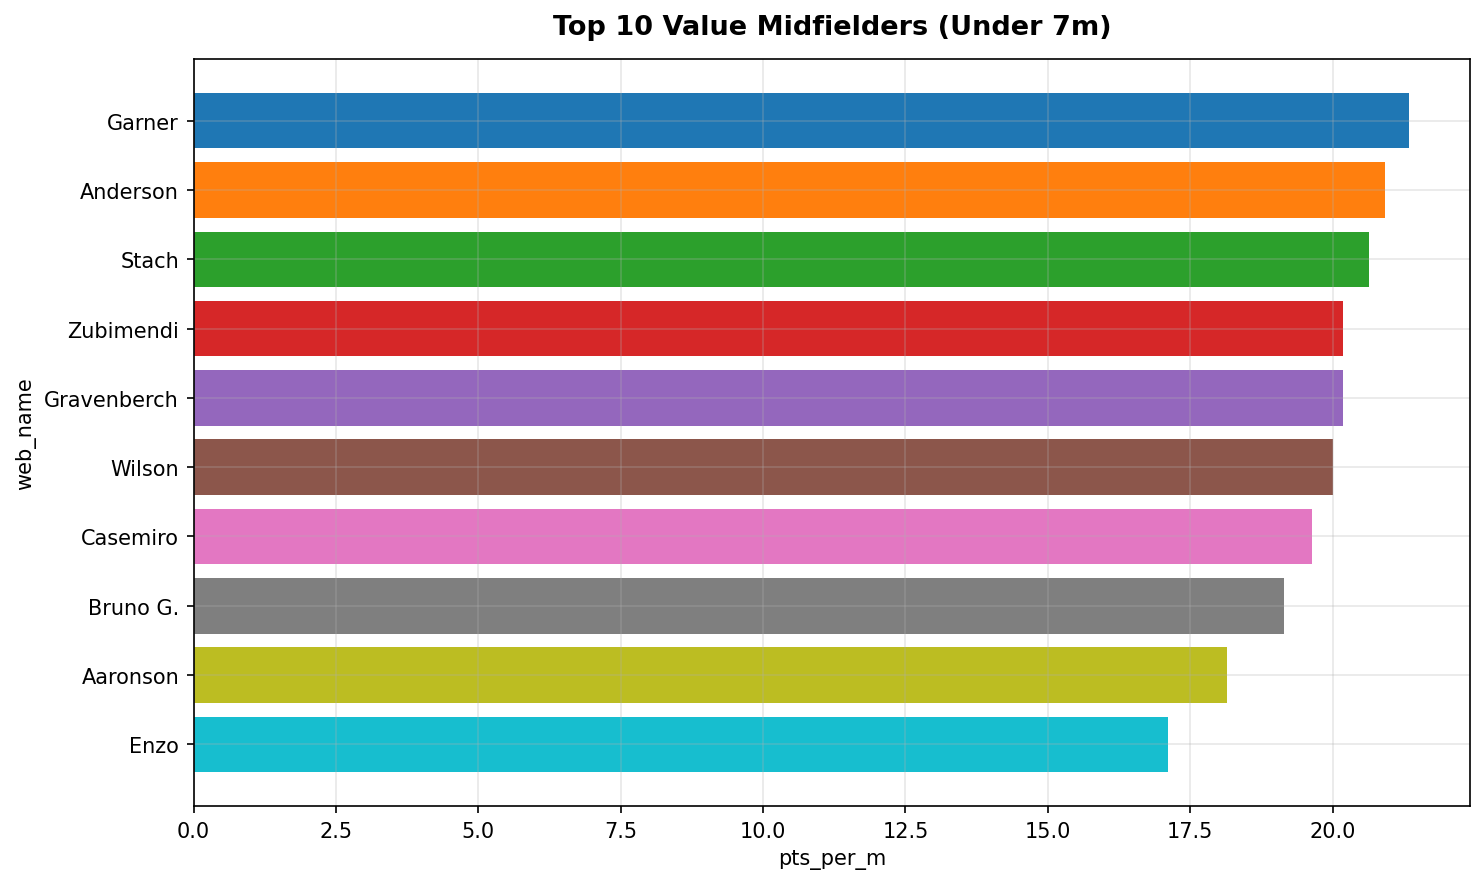

ExecutionResult(stdout='', result=None, dataframes={'mids':                                       id  fpl_id     web_name  \
1   dcf28eaf-67df-43e2-baee-dab9cfe0a2c1      82      Semenyo   
2   3abb9d0e-8e1f-48ae-b5b5-68aaa2d84abf      21         Rice   
3   f466b5ca-5d80-4bb3-a1c5-bae47af330db     449  B.Fernandes   
5   bd52967e-18fe-432f-a56e-8d52b8b88f91     488     Bruno G.   
8   c5489cd5-5236-4f52-9f9d-79a1a89e33df      47       Rogers   
12  38f73c15-eb6e-4216-8171-35eb7f4cf7f1     329       Wilson   
14  7c267858-b80c-43f7-8fd6-bd6efc77932b     237         Enzo   
19  ee89323c-39ed-4989-a7b8-42ef8e0451a9      16         Saka   
20  02c0f725-1431-471d-b1a4-164a2d0b0de7     517     Anderson   
21  05fce028-9bfb-4eea-9aca-b36858596e38     303       Garner   
23  62d3746a-0a6a-49ca-a499-2e721c7b9b76     390  Gravenberch   
24  73175fb3-1183-4f43-a59a-4e18f284361b     457     Casemiro   
26  96375403-9996-4f63-b241-02c8dd6bb6a5     119       Mbeumo   
28  8bbfc26e-fcff-4863-9dc0-19

In [4]:
# GENERATE: bar chart of top value mids
chart_code = '''
mids = df_players[df_players['position'] == 'MID'].copy()
cheap_mids = mids[mids['price'] <= 7.0].copy()
cheap_mids['pts_per_m'] = cheap_mids['total_points'] / cheap_mids['price']
top_value = rank_by(cheap_mids, 'pts_per_m', n=10)
render_bar(top_value, x='web_name', y='pts_per_m', title='Top 10 Value Midfielders (Under 7m)', horizontal=True)
'''

execute_and_report(
    'scouting: cheap mids bar chart',
    chart_code,
    {'df_players': df_players},
)

### Scenario 1b: "compare Salah and Saka last 5 GWs"

READ (players + player_gameweeks) → ANALYZE (rolling form) → GENERATE (line chart)

In [5]:
# READ: find both players, then fetch their GW stats
# In real Alfred flow, this would be 2-3 separate READ steps

# Step 1: Find players by name (no limit — need to search all ~700)
all_players = fetch_enriched('players', order_by='total_points', ascending=False, limit=700)
salah = all_players[all_players['web_name'].str.contains('Salah', case=False, na=False)]
saka = all_players[all_players['web_name'].str.contains('Saka', case=False, na=False)]

if salah.empty or saka.empty:
    print('Could not find both players — adjust names')
    print(f'Salah matches: {len(salah)}, Saka matches: {len(saka)}')
    # Fallback: use top 2 players
    top2 = all_players.head(2)
    player_ids = top2['id'].tolist()
    player_names = top2['web_name'].tolist()
else:
    player_ids = [salah.iloc[0]['id'], saka.iloc[0]['id']]
    player_names = [salah.iloc[0]['web_name'], saka.iloc[0]['web_name']]

print(f'Comparing: {player_names}')

# Step 2: Fetch player_gameweeks
df_player_gameweeks = fetch_df(QuerySpec(
    table='player_gameweeks',
    filters=[Filter('player_id', 'in', player_ids)],
    order_by='gameweek',
    limit=100,
))
print(f'Fetched {len(df_player_gameweeks)} GW records')
print(f'Columns: {df_player_gameweeks.columns.tolist()}')

# Build name map for the executor context
name_map = dict(zip(player_ids, player_names))

Comparing: ['M.Salah', 'Saka']
Fetched 52 GW records
Columns: ['id', 'player_id', 'gameweek', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'total_points', 'in_dreamteam', 'value']


[PASS] scouting: player comparison rolling form + chart (145ms)
Form trends:
                           player_id  total_points  avg_points trend  min_points  max_points  gws_played
74c3e8ae-7112-40e9-9e90-ffeb90d44766            18         3.6    up           0           6           5
ee89323c-39ed-4989-a7b8-42ef8e0451a9            16         3.2    up         
  DataFrame "df": (52, 24) cols=['id', 'player_id', 'gameweek', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded']
  DataFrame "trend": (2, 7) cols=['player_id', 'total_points', 'avg_points', 'trend', 'min_points', 'max_points', 'gws_played']


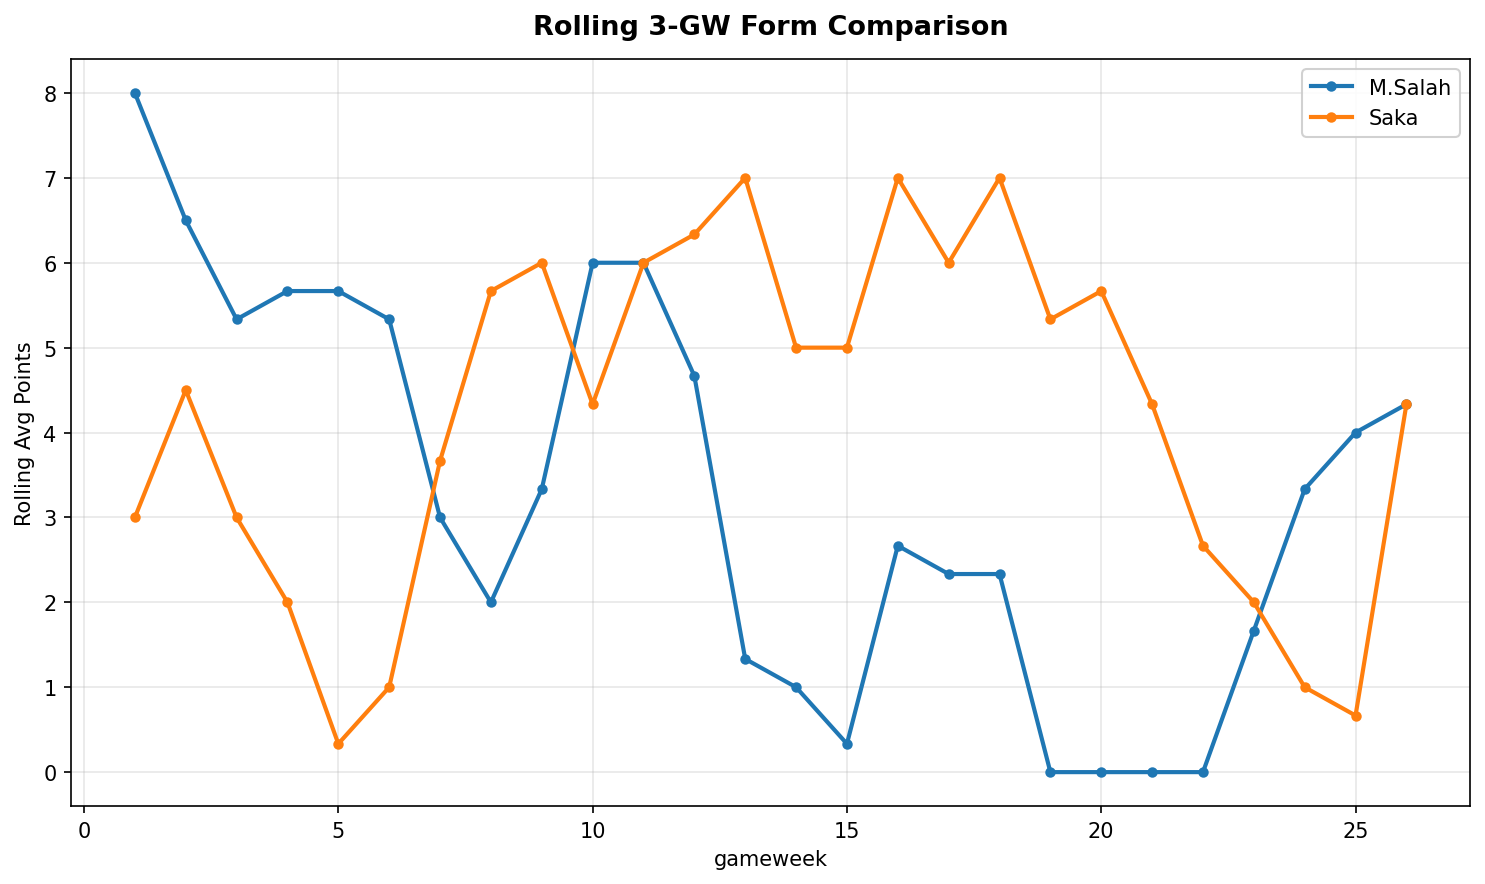

ExecutionResult(stdout='Form trends:\n                           player_id  total_points  avg_points trend  min_points  max_points  gws_played\n74c3e8ae-7112-40e9-9e90-ffeb90d44766            18         3.6    up           0           6           5\nee89323c-39ed-4989-a7b8-42ef8e0451a9            16         3.2    up           0          13           5\n', result=None, dataframes={'df':                                       id  \
0   0df9f141-f9ad-4d5b-a277-abe61e98d638   
1   19d8637b-0eda-4e2d-be96-68760aec1fb3   
2   bfc335f5-0023-44ae-868e-3033760f1e62   
3   e9619955-645a-4ab8-af3c-97ac8a4159f8   
4   992e5dd6-a55b-43b0-b654-3f0c99070bd6   
5   da4e5116-af1b-457a-a772-5d438c112f18   
6   08f60ca4-14b1-4282-bc9c-39f6f2b824bf   
7   1e236b41-c267-42ce-a186-fc1a9585fa61   
8   ae414009-8d65-45ad-8a41-3039196676dc   
9   fc0ede73-77fb-477f-8ffc-2ee0d5681970   
10  e01be887-bd08-487b-9bea-19dd188f0c3e   
11  093bdea2-705b-4d8f-a0db-6b024290dcfe   
12  6a46034d-0190-4546-8866-96e3887df9

In [6]:
# ANALYZE + GENERATE: rolling form comparison
compare_code = '''
# Add player names from the name map
df = df_player_gameweeks.copy()
df['player_name'] = df['player_id'].map(name_map)

# Compute rolling form
df = add_rolling_mean(df, 'total_points', window=3, group_by='player_id')

# Compute form trend
trend = compute_form_trend(df)
print('Form trends:')
print(trend.to_string(index=False))

# Line chart
render_line(
    df, x='gameweek', y='total_points_rolling_3', hue='player_name',
    title='Rolling 3-GW Form Comparison',
    ylabel='Rolling Avg Points',
)
'''

execute_and_report(
    'scouting: player comparison rolling form + chart',
    compare_code,
    {'df_player_gameweeks': df_player_gameweeks, 'name_map': name_map},
)

---
## TIER 1: Squad

Weakest examples — likely to find bugs. Tests: enriched squad → formation + captain analysis.

### Scenario 2a: "show my team"

READ (squads + players) → ANALYZE (formation, squad value) → GENERATE (bar chart)

In [7]:
# READ: squad enriched view
# Note: In real Alfred flow, middleware auto-injects manager_id.
# For testing, we fetch a sample and document exactly what columns come back.

df_squads = fetch_enriched('squad', limit=15)

print(f'Fetched {len(df_squads)} squad picks')
print(f'Columns: {df_squads.columns.tolist()}')
print(f'\nDtypes:')
for col in df_squads.columns:
    print(f'  {col:30s} {str(df_squads[col].dtype):15s}')

if not df_squads.empty:
    print(f'\nSample:')
    display(df_squads.head(5))
    print(f'\n*** KEY FINDING: enriched squad view columns ***')
    print(f'  Has player_name? {"player_name" in df_squads.columns}')
    print(f'  Has player_price? {"player_price" in df_squads.columns}')
    print(f'  Has position? {"position" in df_squads.columns}')  # Likely NO
    print(f'  Has _position_id_label? {"_position_id_label" in df_squads.columns}')  # Also NO

Fetched 15 squad picks
Columns: ['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain', 'is_vice_captain', 'player_name', 'player_price', 'player_form', 'player_total_points']

Dtypes:
  id                             object         
  manager_id                     int64          
  manager_name                   object         
  gameweek                       int64          
  player_id                      object         
  slot                           int64          
  multiplier                     int64          
  is_captain                     bool           
  is_vice_captain                bool           
  player_name                    object         
  player_price                   float64        
  player_form                    float64        
  player_total_points            int64          

Sample:


,id,manager_id,manager_name,gameweek,player_id,slot,multiplier,is_captain,is_vice_captain,player_name,player_price,player_form,player_total_points
0,62361f67-e178-4292-93a8-20bc485a64d1,6578679,Vignesh Jeyaraman,1,7702d8c9-e360-45f4-8176-9f77702ca9b8,1,1,False,True,Sánchez,4.9,2.0,93
1,f538c107-6e0f-4b5f-b701-13f27875691f,6578679,Vignesh Jeyaraman,1,3eb75c09-49b4-4e48-beb9-b7f1b0deb715,2,1,False,False,Saliba,6.1,3.0,84
2,9a0c1f20-f959-4516-967d-6dd8587bf8b0,6578679,Vignesh Jeyaraman,1,19286b3a-af8d-4618-ac61-da62ec3f7e2a,3,1,False,False,Reinildo,3.8,3.0,51
3,cc623df6-8bf5-43fc-8697-b41bfe585704,6578679,Vignesh Jeyaraman,1,0bb920e7-c54e-4fe1-b2d9-2721b742ab75,4,1,False,False,Muñoz,5.9,2.2,98
4,34c830b2-c397-4624-941a-2cad0d91e15d,6578679,Vignesh Jeyaraman,1,b51b459e-9bd8-4596-aafe-8ef759bab243,5,1,False,False,Palmer,10.6,8.5,79



*** KEY FINDING: enriched squad view columns ***
  Has player_name? True
  Has player_price? True
  Has position? False
  Has _position_id_label? False


In [8]:
# ANALYZE: squad composition — tests what the LLM would write
# This uses the CORRECT column names from the enriched squad view

squad_analyze_code = '''
# Squad composition analysis
starting = df_squads[df_squads['slot'] <= 11].copy()
bench = df_squads[df_squads['slot'] > 11].copy()

# Squad value from enriched data
squad_value = starting['player_price'].sum()
bench_value = bench['player_price'].sum()

# Captain
captain = starting[starting['is_captain'] == True]
captain_name = captain['player_name'].iloc[0] if not captain.empty else 'Unknown'

print(f'Starting XI: {len(starting)} players')
print(f'Squad value: {squad_value:.1f}m')
print(f'Bench value: {bench_value:.1f}m')
print(f'Captain: {captain_name}')
print(f'\\nStarting XI:')
for _, row in starting.sort_values('slot').iterrows():
    c_marker = ' (C)' if row.get('is_captain') else ''
    print(f"  {row['slot']:2d}. {row['player_name']:15s} {row['player_price']:5.1f}m  form={row['player_form']}{c_marker}")
'''

# NOTE: df_squads doesn't have position info!
# To compute formation, LLM needs df_players too (from a prior READ)
execute_and_report(
    'squad: composition analysis',
    squad_analyze_code,
    {'df_squads': df_squads},
)

[PASS] squad: composition analysis (3ms)
Starting XI: 11 players
Squad value: 83.3m
Bench value: 16.9m
Captain: Haaland

Starting XI:
   1. Sánchez           4.9m  form=2.0
   2. Saliba            6.1m  form=3.0
   3. Reinildo          3.8m  form=3.0
   4. Muñoz             5.9m  form=2.2
   5. Palmer           10.6m  form=8.5
   6. Mbeumo
  DataFrame "starting": (11, 13) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']
  DataFrame "bench": (4, 13) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']
  DataFrame "captain": (1, 13) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']


ExecutionResult(stdout='Starting XI: 11 players\nSquad value: 83.3m\nBench value: 16.9m\nCaptain: Haaland\n\nStarting XI:\n   1. Sánchez           4.9m  form=2.0\n   2. Saliba            6.1m  form=3.0\n   3. Reinildo          3.8m  form=3.0\n   4. Muñoz             5.9m  form=2.2\n   5. Palmer           10.6m  form=8.5\n   6. Mbeumo            8.6m  form=6.5\n   7. Kudus             6.4m  form=0.0\n   8. Minteh            5.6m  form=1.0\n   9. Gyökeres          8.8m  form=4.6\n  10. Haaland          14.9m  form=5.5 (C)\n  11. João Pedro        7.7m  form=10.0\n', result=None, dataframes={'starting':                                       id  manager_id       manager_name  \
0   62361f67-e178-4292-93a8-20bc485a64d1     6578679  Vignesh Jeyaraman   
1   f538c107-6e0f-4b5f-b701-13f27875691f     6578679  Vignesh Jeyaraman   
2   9a0c1f20-f959-4516-967d-6dd8587bf8b0     6578679  Vignesh Jeyaraman   
3   cc623df6-8bf5-43fc-8697-b41bfe585704     6578679  Vignesh Jeyaraman   
4   34c830b2-c397

In [ ]:
# ANALYZE: formation computation — requires BOTH squad + player data
# This is the pattern squad:analyze examples SHOULD teach

# Fetch enriched players for position info
df_players_full = fetch_enriched('players', limit=200)

formation_code = '''
# Compute formation by merging squad picks with player data
starting = df_squads[df_squads['slot'] <= 11].copy()

# Merge with players to get position
starting_enriched = starting.merge(
    df_players[['id', 'web_name', 'position', 'price', 'form', 'total_points']],
    left_on='player_id',
    right_on='id',
    how='left',
)

# Formation
if 'position' in starting_enriched.columns:
    pos_counts = starting_enriched['position'].value_counts()
    formation_parts = []
    for pos in ['DEF', 'MID', 'FWD']:
        formation_parts.append(str(pos_counts.get(pos, 0)))
    formation = '-'.join(formation_parts)
    print(f'Formation: {formation}')
    print(f'\\nPosition breakdown:')
    print(pos_counts.to_string())
else:
    print('ERROR: No position column after merge — check player data')

# Bar chart of starting XI by form
if not starting_enriched.empty:
    render_bar(
        starting_enriched.sort_values('form', ascending=False),
        x='web_name', y='form',
        title='Starting XI: Form Rating',
        horizontal=True,
    )
'''

execute_and_report(
    'squad: formation computation with player merge',
    formation_code,
    {'df_squads': df_squads, 'df_players': df_players_full},
)

### Scenario 2b: "captain analysis"

READ (squad + player_gameweeks) → ANALYZE (captain vs alternatives) → GENERATE (comparison chart)

In [9]:
# ANALYZE: captain analysis — compare captain choice vs top alternatives
captain_code = '''
starting = df_squads[df_squads['slot'] <= 11].copy()

# Find captain
captain = starting[starting['is_captain'] == True]
if captain.empty:
    print('No captain found in squad data')
else:
    cap_name = captain['player_name'].iloc[0]
    cap_points = captain['player_total_points'].iloc[0]
    cap_form = captain['player_form'].iloc[0]
    
    # Top 3 alternatives by form (non-captain)
    alternatives = starting[starting['is_captain'] != True].copy()
    top_alts = alternatives.nlargest(3, 'player_form')
    
    print(f'Captain: {cap_name} (form={cap_form}, total_pts={cap_points})')
    print(f'\\nTop 3 alternatives by form:')
    for _, alt in top_alts.iterrows():
        diff = alt['player_form'] - cap_form
        indicator = '+' if diff > 0 else ''
        print(f"  {alt['player_name']:15s} form={alt['player_form']} ({indicator}{diff:.1f} vs captain)")
'''

execute_and_report(
    'squad: captain analysis',
    captain_code,
    {'df_squads': df_squads},
)

[PASS] squad: captain analysis (3ms)
Captain: Haaland (form=5.5, total_pts=187)

Top 3 alternatives by form:
  João Pedro      form=10.0 (+4.5 vs captain)
  Palmer          form=8.5 (+3.0 vs captain)
  Mbeumo          form=6.5 (+1.0 vs captain)

  DataFrame "starting": (11, 13) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']
  DataFrame "captain": (1, 13) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']
  DataFrame "alternatives": (10, 13) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']
  DataFrame "top_alts": (3, 13) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']


ExecutionResult(stdout='Captain: Haaland (form=5.5, total_pts=187)\n\nTop 3 alternatives by form:\n  João Pedro      form=10.0 (+4.5 vs captain)\n  Palmer          form=8.5 (+3.0 vs captain)\n  Mbeumo          form=6.5 (+1.0 vs captain)\n', result=None, dataframes={'starting':                                       id  manager_id       manager_name  \
0   62361f67-e178-4292-93a8-20bc485a64d1     6578679  Vignesh Jeyaraman   
1   f538c107-6e0f-4b5f-b701-13f27875691f     6578679  Vignesh Jeyaraman   
2   9a0c1f20-f959-4516-967d-6dd8587bf8b0     6578679  Vignesh Jeyaraman   
3   cc623df6-8bf5-43fc-8697-b41bfe585704     6578679  Vignesh Jeyaraman   
4   34c830b2-c397-4624-941a-2cad0d91e15d     6578679  Vignesh Jeyaraman   
5   ee3f9814-3ec6-4a12-a010-ba09878c0e93     6578679  Vignesh Jeyaraman   
6   c86965b6-0dc8-4797-bfa2-5e493fa2fa7c     6578679  Vignesh Jeyaraman   
7   1112ab1a-16b5-4d28-925b-f71cbdeb08ae     6578679  Vignesh Jeyaraman   
8   c9c29f6e-9594-496f-a655-6cdc4679ff34     65

---
## TIER 1: Fixtures

FDR computation used by scouting + market. Tests: enriched fixtures → FDR grid → heatmap.

### Scenario 3a: "easiest fixtures next 5 GWs"

READ (fixtures) → ANALYZE (FDR grid, team ranking) → GENERATE (heatmap)

In [10]:
# READ: enriched fixtures
df_fixtures = fetch_enriched(
    'fixtures',
    filters=[Filter('finished', 'eq', False)],
    order_by='gameweek',
    limit=100,
)
print(f'Fetched {len(df_fixtures)} upcoming fixtures')
print(f'Columns: {df_fixtures.columns.tolist()}')
if not df_fixtures.empty:
    print(f'GW range: {df_fixtures["gameweek"].min()} - {df_fixtures["gameweek"].max()}')
    display(df_fixtures.head(5))

Fetched 100 upcoming fixtures
Columns: ['id', 'fpl_id', 'gameweek', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'kickoff_time', 'finished', 'home_difficulty', 'away_difficulty', 'home_team', 'away_team']
GW range: 27 - 37


,id,fpl_id,gameweek,home_team_id,away_team_id,home_score,away_score,kickoff_time,finished,home_difficulty,away_difficulty,home_team,away_team
0,02361fab-18ab-412d-bba2-26dbdeb49951,261,27,cffb19a4-cf18-49ce-b104-e6b7b8666774,2cf4f988-3734-4604-980c-c12ff9bacab9,None,None,2026-02-21T15:00:00+00:00,False,2,4,AVL,LEE
1,f8276c9a-afa9-4f12-9ab2-6b696a32b355,262,27,63fa2f6d-9cea-4fc2-a67d-5ccb83858438,c23ae067-0139-431e-b77d-dca314a4ac93,None,None,2026-02-21T15:00:00+00:00,False,3,4,BRE,BHA
2,9cc50892-b9f1-41ea-a202-88aea0bd9b0e,263,27,c88c9f37-5e4e-4454-b04b-48a6c4d0ada2,1feddd3a-179d-49df-aaa0-6200e6cadd9d,None,None,2026-02-21T15:00:00+00:00,False,1,4,CHE,BUR
3,25ac285f-2bc1-436a-aaec-5d9a0e7ff24b,270,27,90a000db-fa4c-4210-8900-1c36c05ac738,72eb7751-8342-432d-9f50-f84aa6802191,None,None,2026-02-21T17:30:00+00:00,False,3,2,WHU,BOU
4,1a24de18-5ac6-4200-b052-a9f5605efa43,266,27,b92b7b52-cce8-4c07-97c0-ae90479b849b,e7b15cef-50e1-4d14-969d-f4b691c8e1d6,None,None,2026-02-21T20:00:00+00:00,False,3,5,MCI,NEW


[PASS] fixtures: FDR ranking + heatmap (247ms)
Top 10 easiest fixture runs:
  AVL : avg FDR = 2.64
  ARS : avg FDR = 2.80
  CRY : avg FDR = 2.89
  MCI : avg FDR = 2.89
  WOL : avg FDR = 2.89
  BRE : avg FDR = 2.90
  LEE : avg FDR = 2.90
  BOU : avg FDR = 2.90
  SUN : avg FDR = 2.90
  LIV : avg FDR = 2.91

  DataFrame "fdr_df": (200, 3) cols=['team', 'gameweek', 'fdr']
  DataFrame "pivot": (10, 5) cols=['GW27', 'GW28', 'GW29', 'GW30', 'GW31']


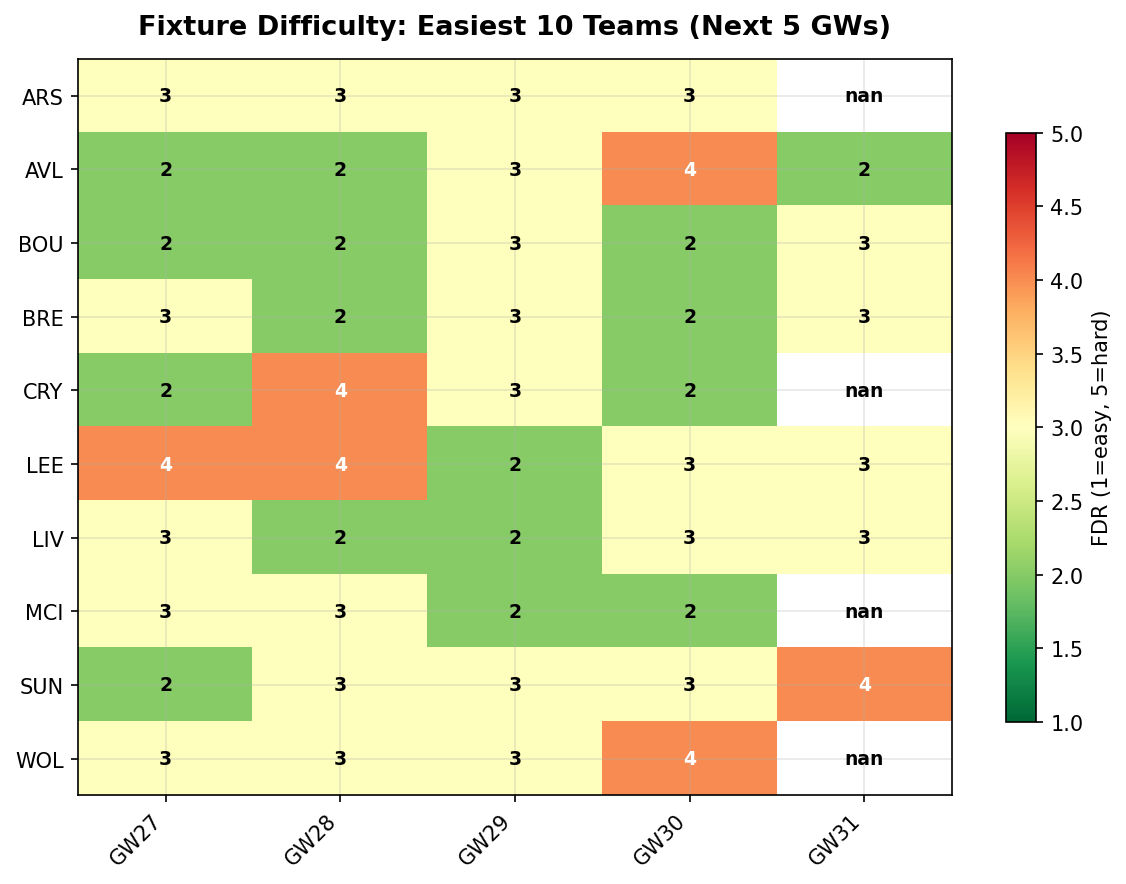

ExecutionResult(stdout='Top 10 easiest fixture runs:\n  AVL : avg FDR = 2.64\n  ARS : avg FDR = 2.80\n  CRY : avg FDR = 2.89\n  MCI : avg FDR = 2.89\n  WOL : avg FDR = 2.89\n  BRE : avg FDR = 2.90\n  LEE : avg FDR = 2.90\n  BOU : avg FDR = 2.90\n  SUN : avg FDR = 2.90\n  LIV : avg FDR = 2.91\n', result=None, dataframes={'fdr_df':     team  gameweek  fdr
0    AVL        27    2
1    LEE        27    4
2    BRE        27    3
3    BHA        27    4
4    CHE        27    1
..   ...       ...  ...
195  ARS        36    2
196  ARS        37    1
197  BUR        37    5
198  AVL        37    3
199  LIV        37    4

[200 rows x 3 columns], 'pivot':       GW27  GW28  GW29  GW30  GW31
team                              
ARS    3.0   3.0   3.0   3.0   NaN
AVL    2.0   2.0   3.0   4.0   2.0
BOU    2.0   2.0   3.0   2.0   3.0
BRE    3.0   2.0   3.0   2.0   3.0
CRY    2.0   4.0   3.0   2.0   NaN
LEE    4.0   4.0   2.0   3.0   3.0
LIV    3.0   2.0   2.0   3.0   3.0
MCI    3.0   3.0   2.0   2.0   

In [11]:
# ANALYZE + GENERATE: FDR heatmap — the exact pattern from fixtures:analyze
fdr_code = '''
# Build team FDR grid from enriched fixtures
rows = []
for _, fix in df_fixtures.iterrows():
    gw = fix.get('gameweek')
    if pd.isna(gw):
        continue
    # Correct FDR: home_difficulty for home team, away_difficulty for away team
    rows.append({'team': fix['home_team'], 'gameweek': int(gw), 'fdr': fix.get('home_difficulty', 3)})
    rows.append({'team': fix['away_team'], 'gameweek': int(gw), 'fdr': fix.get('away_difficulty', 3)})

fdr_df = pd.DataFrame(rows)

# Top 10 teams by average FDR (easiest)
avg_fdr = fdr_df.groupby('team')['fdr'].mean().sort_values()
top_teams = avg_fdr.head(10).index.tolist()

print('Top 10 easiest fixture runs:')
for team in top_teams:
    print(f'  {team:4s}: avg FDR = {avg_fdr[team]:.2f}')

# Heatmap: pivot to team x GW
gws = sorted(fdr_df['gameweek'].unique())[:5]
pivot = fdr_df[fdr_df['team'].isin(top_teams) & fdr_df['gameweek'].isin(gws)].pivot_table(
    index='team', columns='gameweek', values='fdr', aggfunc='first'
)
pivot.columns = [f'GW{int(c)}' for c in pivot.columns]
render_heatmap(pivot, title='Fixture Difficulty: Easiest 10 Teams (Next 5 GWs)')
'''

execute_and_report(
    'fixtures: FDR ranking + heatmap',
    fdr_code,
    {'df_fixtures': df_fixtures},
)

### Scenario 3b: "Arsenal fixture run"

READ (fixtures for specific team) → ANALYZE (compute_fixture_difficulty) → table output

In [12]:
# ANALYZE: use compute_fixture_difficulty helper
# First find Arsenal's team_id from fixtures

team_run_code = '''
# Find a team_id from enriched fixtures
# Look for Arsenal (ARS) in home_team or away_team columns
ars_home = df_fixtures[df_fixtures['home_team'] == 'ARS']
ars_away = df_fixtures[df_fixtures['away_team'] == 'ARS']

if not ars_home.empty:
    ars_id = ars_home.iloc[0]['home_team_id']
elif not ars_away.empty:
    ars_id = ars_away.iloc[0]['away_team_id']
else:
    print('Arsenal not found in fixtures')
    ars_id = None

if ars_id:
    # Use the BI library helper
    fdr = compute_fixture_difficulty(df_fixtures, team_id=ars_id, n_gws=5)
    print(f'Arsenal fixture run (next 5 GWs):')
    print(fdr.to_string(index=False))
'''

execute_and_report(
    'fixtures: Arsenal fixture difficulty (library fn)',
    team_run_code,
    {'df_fixtures': df_fixtures},
)

[PASS] fixtures: Arsenal fixture difficulty (library fn) (5ms)
Arsenal fixture run (next 5 GWs):
 gameweek                          opponent_id  is_home  fdr opponent
       27 9ae387a9-04ce-4c92-8586-2146e050ace3    False    3      TOT
       28 c88c9f37-5e4e-4454-b04b-48a6c4d0ada2     True    3      CHE
       29 c23ae067-0139-431e-b77d-dca314a4ac93    False 
  DataFrame "ars_home": (6, 13) cols=['id', 'fpl_id', 'gameweek', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'kickoff_time']
  DataFrame "ars_away": (4, 13) cols=['id', 'fpl_id', 'gameweek', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'kickoff_time']
  DataFrame "fdr": (5, 5) cols=['gameweek', 'opponent_id', 'is_home', 'fdr', 'opponent']


ExecutionResult(stdout='Arsenal fixture run (next 5 GWs):\n gameweek                          opponent_id  is_home  fdr opponent\n       27 9ae387a9-04ce-4c92-8586-2146e050ace3    False    3      TOT\n       28 c88c9f37-5e4e-4454-b04b-48a6c4d0ada2     True    3      CHE\n       29 c23ae067-0139-431e-b77d-dca314a4ac93    False    3      BHA\n       30 3d8ff8e6-d3ea-455a-a61c-4a77885a9454     True    3      EVE\n       32 72eb7751-8342-432d-9f50-f84aa6802191     True    3      BOU\n', result=None, dataframes={'ars_home':                                       id  fpl_id  gameweek  \
19  5c97bfb0-6800-4ab5-ae7a-d2eee14f55c9     271        28   
35  98b6fe6c-8559-47fc-9e9f-401d8c0fdff9     291        30   
48  7a48b5db-aebf-45ff-a60b-32cf9c575688     311        32   
68  0357a134-efa0-4113-979a-c6f6b83ba184     331        34   
78  2928b2af-363c-491c-9139-b349b82d9bee     341        35   
98  59f76c66-cf5c-48e3-8226-a80417be7660     361        37   

                            home_team_id

---
## TIER 2: League

### Scenario 4a: "how am I doing vs rival?"

In [13]:
# READ: league standings
df_league_standings = fetch_df(QuerySpec(
    table='league_standings',
    order_by='gameweek',
    ascending=False,
    limit=50,
))
print(f'Fetched {len(df_league_standings)} standings rows')
print(f'Columns: {df_league_standings.columns.tolist()}')
if not df_league_standings.empty:
    display(df_league_standings.head(5))
    print(f'Managers: {df_league_standings["manager_name"].unique()[:5].tolist() if "manager_name" in df_league_standings.columns else "no manager_name column"}')

Fetched 50 standings rows
Columns: ['id', 'league_id', 'league_name', 'gameweek', 'manager_id', 'manager_name', 'team_name', 'rank', 'last_rank', 'total_points', 'event_points']


,id,league_id,league_name,gameweek,manager_id,manager_name,team_name,rank,last_rank,total_points,event_points
0,4a76e4e3-31bb-450a-8e59-cd0ef91ef5d8,1486488,Abe Yaar,26,6578679,Vignesh Jeyaraman,Kiseki no sedai,6,9,1445,68
1,b2326595-0d79-4088-b027-59de43c85759,1486488,Abe Yaar,26,7255157,Kiran Kasshyap,The Lasso Way,22,22,1048,51
2,1af42c98-f104-4484-99b6-c223fd985909,1486488,Abe Yaar,26,3888535,Prashanth Venkatraman,thayirsadam,14,13,1383,43
3,d1e9054c-9123-4108-851a-87e4fb83513c,1486488,Abe Yaar,26,612182,Keerthikaran Karunakaran,JellyfishDoctor,7,7,1444,70
4,8572fb1f-7347-41ab-ad90-84178b1f053a,1486488,Abe Yaar,26,2901215,Rishwanth R,RishX1,3,3,1477,53


Managers: ['Vignesh Jeyaraman', 'Kiran Kasshyap', 'Prashanth Venkatraman', 'Keerthikaran Karunakaran', 'Rishwanth R']


In [14]:
# ANALYZE: rivalry comparison
rivalry_code = '''
if df_league_standings.empty:
    print('No league data available')
else:
    # Get two managers to compare
    managers = df_league_standings['manager_name'].unique()[:2]
    if len(managers) < 2:
        print(f'Need at least 2 managers, found {len(managers)}')
    else:
        my_data = df_league_standings[df_league_standings['manager_name'] == managers[0]].sort_values('gameweek')
        rival_data = df_league_standings[df_league_standings['manager_name'] == managers[1]].sort_values('gameweek')
        
        print(f'Comparing: {managers[0]} vs {managers[1]}')
        
        if not my_data.empty and not rival_data.empty:
            my_latest = my_data.iloc[-1]
            rival_latest = rival_data.iloc[-1]
            gap = my_latest.get('total_points', 0) - rival_latest.get('total_points', 0)
            print(f'  {managers[0]}: rank={my_latest.get("rank", "?")}, pts={my_latest.get("total_points", "?")}')
            print(f'  {managers[1]}: rank={rival_latest.get("rank", "?")}, pts={rival_latest.get("total_points", "?")}')
            print(f'  Gap: {gap:+d} points')
'''

execute_and_report(
    'league: rivalry comparison',
    rivalry_code,
    {'df_league_standings': df_league_standings},
)

[PASS] league: rivalry comparison (1ms)
Comparing: Vignesh Jeyaraman vs Kiran Kasshyap
  Vignesh Jeyaraman: rank=6, pts=1445
  Kiran Kasshyap: rank=22, pts=1048
  Gap: +397 points

  DataFrame "my_data": (3, 11) cols=['id', 'league_id', 'league_name', 'gameweek', 'manager_id', 'manager_name', 'team_name', 'rank']
  DataFrame "rival_data": (2, 11) cols=['id', 'league_id', 'league_name', 'gameweek', 'manager_id', 'manager_name', 'team_name', 'rank']


ExecutionResult(stdout='Comparing: Vignesh Jeyaraman vs Kiran Kasshyap\n  Vignesh Jeyaraman: rank=6, pts=1445\n  Kiran Kasshyap: rank=22, pts=1048\n  Gap: +397 points\n', result=None, dataframes={'my_data':                                       id  league_id league_name  gameweek  \
49  5fb80edc-e487-424c-8c5a-5e1ce5ba5c03    1486488    Abe Yaar        24   
26  2ffec239-2d8f-4f91-adb4-463220cdd198    1486488    Abe Yaar        25   
0   4a76e4e3-31bb-450a-8e59-cd0ef91ef5d8    1486488    Abe Yaar        26   

    manager_id       manager_name        team_name  rank  last_rank  \
49     6578679  Vignesh Jeyaraman  Kiseki no sedai     6          9   
26     6578679  Vignesh Jeyaraman  Kiseki no sedai     6          9   
0      6578679  Vignesh Jeyaraman  Kiseki no sedai     6          9   

    total_points  event_points  
49          1445            68  
26          1445            68  
0           1445            68  , 'rival_data':                                       id  league_id 

---
## TIER 2: Market

### Scenario 5a: "who should I replace Haaland with?"

[PASS] market: FWD replacement comparison (99ms)
Top 5 FWD replacements (composite: form + value):
 rank      web_name team  price  form  pts_per_m  composite_score
    1    João Pedro  CHE    7.7  10.0  17.142857         1.902256
    2         Bowen  WHU    7.6   6.8  15.789474         1.511025
    3        Thiago  BRE    7.0   2.8  19.000000    
  DataFrame "fwds": (6, 25) cols=['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price']
  DataFrame "top_replacements": (5, 26) cols=['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price']


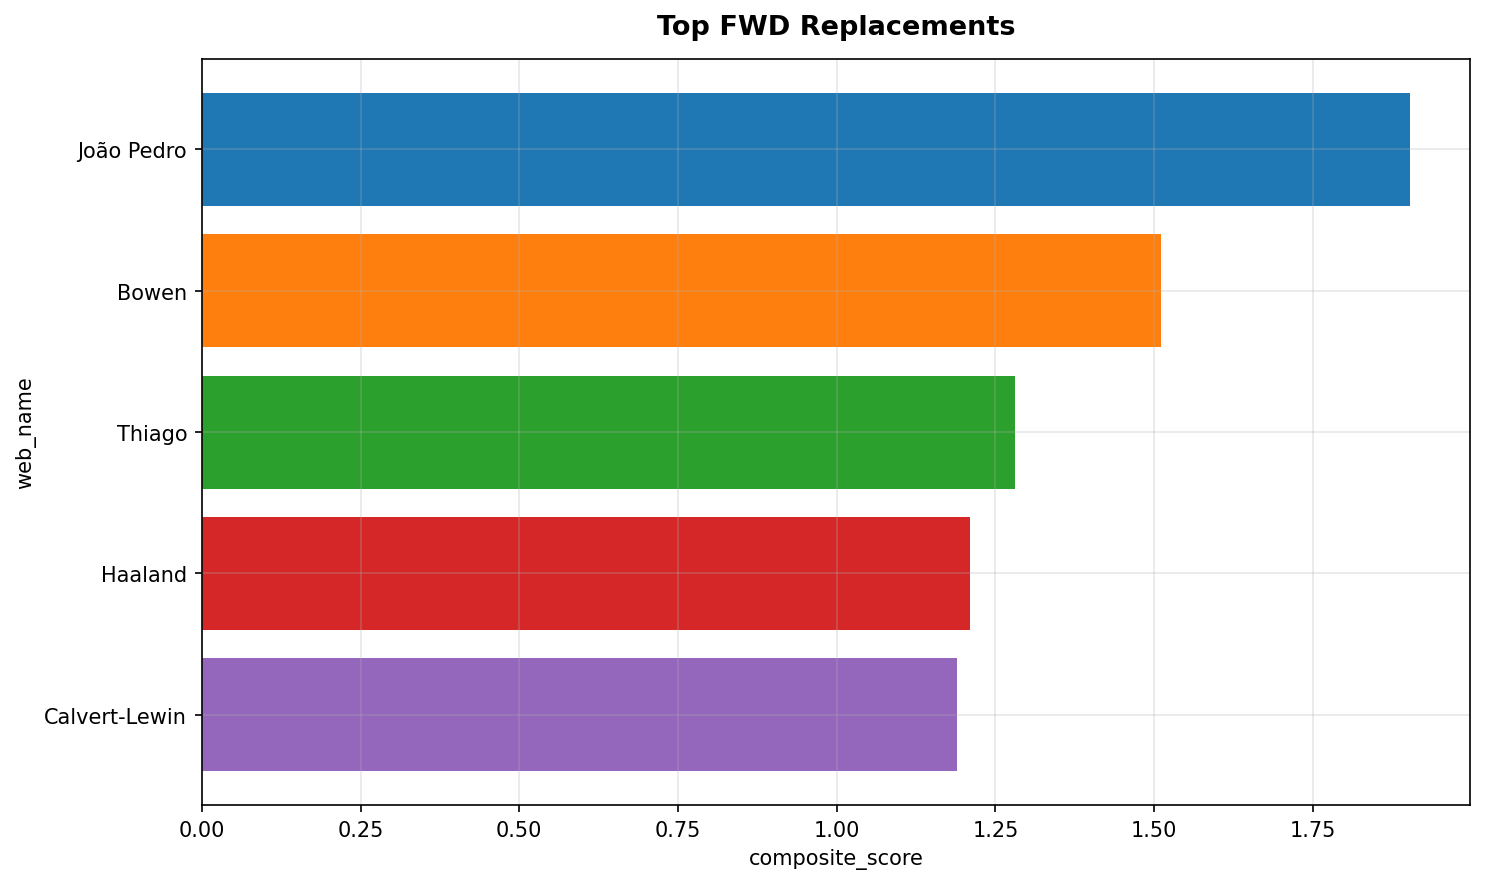

ExecutionResult(stdout='Top 5 FWD replacements (composite: form + value):\n rank      web_name team  price  form  pts_per_m  composite_score\n    1    João Pedro  CHE    7.7  10.0  17.142857         1.902256\n    2         Bowen  WHU    7.6   6.8  15.789474         1.511025\n    3        Thiago  BRE    7.0   2.8  19.000000         1.280000\n    4       Haaland  MCI   14.9   5.5  12.550336         1.210544\n    5 Calvert-Lewin  LEE    5.9   2.8  17.288136         1.189902\n', result=None, dataframes={'fwds':                                       id  fpl_id       web_name   first_name  \
0   094a2dc5-5419-4a10-9662-a9406ae85125     430        Haaland       Erling   
6   12863141-9025-403d-957d-308cba42e8ac     136         Thiago  Igor Thiago   
7   8cfb779d-11d5-4758-8b1f-c7df78acbe67     249     João Pedro   João Pedro   
13  196d8c39-e654-4765-911d-b0894bb33e40     624          Bowen       Jarrod   
32  466aec31-c40c-48b7-ad94-3edfef78f898     661        Ekitiké         Hugo   
36  da3

In [15]:
# READ: get FWDs for replacement comparison
df_fwds = fetch_enriched(
    'players',
    order_by='total_points',
    ascending=False,
    limit=50,
)

# ANALYZE: replacement comparison with composite ranking
replacement_code = '''
# Filter to FWDs
fwds = df_players[df_players['position'] == 'FWD'].copy()

if fwds.empty:
    print('No forwards found')
else:
    # Compute value metrics
    fwds['pts_per_m'] = fwds['total_points'] / fwds['price']
    
    # Composite score: normalize form + pts_per_m
    fwds['form_norm'] = fwds['form'] / fwds['form'].max() if fwds['form'].max() > 0 else 0
    fwds['value_norm'] = fwds['pts_per_m'] / fwds['pts_per_m'].max() if fwds['pts_per_m'].max() > 0 else 0
    fwds['composite_score'] = fwds['form_norm'] + fwds['value_norm']
    
    top_replacements = rank_by(fwds, 'composite_score', n=5)
    print('Top 5 FWD replacements (composite: form + value):')
    print(top_replacements[['rank', 'web_name', 'team', 'price', 'form', 'pts_per_m', 'composite_score']].to_string(index=False))
    
    render_bar(top_replacements, x='web_name', y='composite_score', title='Top FWD Replacements', horizontal=True)
'''

execute_and_report(
    'market: FWD replacement comparison',
    replacement_code,
    {'df_players': df_fwds},
)

---
## TIER 2: Live

### Scenario 6a: "how's this week going?"

In [16]:
# READ: squad + player_gameweeks for current GW
# Note: this requires squad data to exist for a specific GW

live_code = '''
if df_squads.empty:
    print('No squad data available for live analysis')
else:
    # Get player_ids from squad
    starting = df_squads[df_squads['slot'] <= 11].copy()
    bench = df_squads[df_squads['slot'] > 11].copy()
    
    # Compute live total using enriched data
    starting['effective_pts'] = starting['player_total_points'] * starting.get('multiplier', 1)
    live_total = starting['effective_pts'].sum()
    bench_pts = bench['player_total_points'].sum()
    
    # Captain return
    captain = starting[starting['is_captain'] == True]
    cap_pts = captain['effective_pts'].iloc[0] if not captain.empty else 0
    
    print(f'Live Total: {live_total:.0f} pts')
    print(f'Captain return: {cap_pts:.0f} pts ({captain["player_name"].iloc[0] if not captain.empty else "?"})')
    print(f'Bench points: {bench_pts:.0f} pts')
    print(f'\\nNote: Uses total_points from enriched squad view (not GW-specific).') 
    print('For accurate live scoring, merge with player_gameweeks for current GW.')
'''

execute_and_report(
    'live: GW scorecard',
    live_code,
    {'df_squads': df_squads},
)

[PASS] live: GW scorecard (2ms)
Live Total: 1257 pts
Captain return: 374 pts (Haaland)
Bench points: 244 pts

Note: Uses total_points from enriched squad view (not GW-specific).
For accurate live scoring, merge with player_gameweeks for current GW.

  DataFrame "starting": (11, 14) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']
  DataFrame "bench": (4, 13) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']
  DataFrame "captain": (1, 14) cols=['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain']


ExecutionResult(stdout='Live Total: 1257 pts\nCaptain return: 374 pts (Haaland)\nBench points: 244 pts\n\nNote: Uses total_points from enriched squad view (not GW-specific).\nFor accurate live scoring, merge with player_gameweeks for current GW.\n', result=None, dataframes={'starting':                                       id  manager_id       manager_name  \
0   62361f67-e178-4292-93a8-20bc485a64d1     6578679  Vignesh Jeyaraman   
1   f538c107-6e0f-4b5f-b701-13f27875691f     6578679  Vignesh Jeyaraman   
2   9a0c1f20-f959-4516-967d-6dd8587bf8b0     6578679  Vignesh Jeyaraman   
3   cc623df6-8bf5-43fc-8697-b41bfe585704     6578679  Vignesh Jeyaraman   
4   34c830b2-c397-4624-941a-2cad0d91e15d     6578679  Vignesh Jeyaraman   
5   ee3f9814-3ec6-4a12-a010-ba09878c0e93     6578679  Vignesh Jeyaraman   
6   c86965b6-0dc8-4797-bfa2-5e493fa2fa7c     6578679  Vignesh Jeyaraman   
7   1112ab1a-16b5-4d28-925b-f71cbdeb08ae     6578679  Vignesh Jeyaraman   
8   c9c29f6e-9594-496f-a655-6cdc4679ff

---
## Scorecard — Summary of All Scenarios

In [17]:
# Final scorecard
print(f'\n{"="*70}')
print('SCORECARD: All Scenarios')
print(f'{"="*70}')

passed = sum(1 for r in scorecard if r['success'])
failed = sum(1 for r in scorecard if not r['success'])

for r in scorecard:
    status = 'PASS' if r['success'] else 'FAIL'
    charts = f" [{r['chart_count']} charts]" if r['chart_count'] else ''
    dfs = f" [{', '.join(r['df_names'])}]" if r['df_names'] else ''
    print(f'  [{status}] {r["label"]}{charts}{dfs} ({r["duration_ms"]}ms)')
    if r.get('missing_columns'):
        print(f'         Missing cols: {r["missing_columns"]}')
    if not r['success']:
        print(f'         Error: {r["error"][:100]}')

print(f'\nTotal: {passed} passed, {failed} failed out of {len(scorecard)}')
if failed == 0:
    print('All scenarios passed! Prompts are safe to use.')
else:
    print('\nFailed scenarios need prompt fixes before going live.')


SCORECARD: All Scenarios
  [PASS] scouting: cheap mids pts_per_m [mids, cheap_mids, result] (7ms)
  [PASS] scouting: cheap mids bar chart [1 charts] [mids, cheap_mids, top_value] (143ms)
  [PASS] scouting: player comparison rolling form + chart [1 charts] [df, trend] (145ms)
  [PASS] squad: composition analysis [starting, bench, captain] (3ms)
  [PASS] squad: captain analysis [starting, captain, alternatives, top_alts] (3ms)
  [PASS] fixtures: FDR ranking + heatmap [1 charts] [fdr_df, pivot] (247ms)
  [PASS] fixtures: Arsenal fixture difficulty (library fn) [ars_home, ars_away, fdr] (5ms)
  [PASS] league: rivalry comparison [my_data, rival_data] (1ms)
  [PASS] market: FWD replacement comparison [1 charts] [fwds, top_replacements] (99ms)
  [PASS] live: GW scorecard [starting, bench, captain] (2ms)

Total: 10 passed, 0 failed out of 10
All scenarios passed! Prompts are safe to use.
